In [ ]:

!pip install -U xgboost optuna optuna-integration scikit-learn matplotlib seaborn --no-cache-dir -q

import os
import gc
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

def configure_gpu():
    try:
        X_demo = np.random.rand(500, 20).astype(np.float32)
        y_demo = np.random.randint(0, 2, 500)
        dtrain = xgb.DMatrix(X_demo, label=y_demo, enable_categorical=True)
        xgb.train(
            params={"objective": "binary:logistic", "device": "cuda", "tree_method": "hist"},
            dtrain=dtrain,
            num_boost_round=1
        )
        print("GPU acceleration enabled")
        return True
    except:
        print(" GPU not available, using CPU.")
        return False

USE_XGB_GPU = configure_gpu()


def reduce_memory_usage(df):
    start = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type in ["int64", "int32"]:
            c_min, c_max = df[col].min(), df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            else:
                df[col] = df[col].astype(np.int32)
        elif col_type == "float64":
            df[col] = df[col].astype(np.float32)
    end = df.memory_usage().sum() / 1024**2
    print(f"Memory optimized: {start:.2f} MB → {end:.2f} MB")
    return df


TRAIN_PATH = "/content/train.csv"
TEST_PATH = "/content/test.csv"
TARGET_COL = "WeightCategory"
ID_COL = "id"

N_SPLITS = 5

try:
    train = pd.read_csv(TRAIN_PATH)
    test = pd.read_csv(TEST_PATH)
    train = reduce_memory_usage(train)
    test = reduce_memory_usage(test)
except FileNotFoundError:
    print("FileNotFoundError: Please upload train.csv and test.csv to /content/")
    # Creating dummy data to allow the script to run for demonstration
    train = pd.DataFrame({
        'id': range(100), 'Weight': np.random.uniform(50, 100, 100),
        'Height': np.random.uniform(150, 200, 100),
        'Feature1': np.random.rand(100), 'Gender': np.random.choice(['Male', 'Female'], 100),
        'WeightCategory': np.random.choice(['Normal', 'Overweight', 'Obese'], 100)
    })
    test = pd.DataFrame({
        'id': range(100, 150), 'Weight': np.random.uniform(50, 100, 50),
        'Height': np.random.uniform(150, 200, 50),
        'Feature1': np.random.rand(50), 'Gender': np.random.choice(['Male', 'Female'], 50)
    })
    print("Using dummy data to proceed...")



def add_bmi_category(df):
    if "Weight" in df.columns and "Height" in df.columns:
        # Ensure Height is in meters for BMI calculation
        df["BMI"] = df["Weight"] / ((df["Height"] / 100) ** 2)
        conditions = [
            (df["BMI"] < 18.5),
            (df["BMI"] >= 18.5) & (df["BMI"] < 25),
            (df["BMI"] >= 25) & (df["BMI"] < 30),
            (df["BMI"] >= 30) & (df["BMI"] < 35),
            (df["BMI"] >= 35)
        ]
        categories = ["Underweight", "Normal", "Overweight", "Obese", "Extremely Obese"]
        df["BMI_Category"] = np.select(conditions, categories, default='Unknown') # Set default to a string
        df.drop(columns=["BMI"], inplace=True)
    return df

train = add_bmi_category(train)
test = add_bmi_category(test)

X = train.drop(columns=[TARGET_COL, ID_COL], errors="ignore")
y = train[TARGET_COL]
test_features = test.drop(columns=[ID_COL], errors="ignore")

train_cols = X.columns
test_cols = test_features.columns

test_features = test_features[train_cols.drop(TARGET_COL, errors='ignore')]


cat_cols = X.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    X[col] = X[col].astype("category")
    if col in test_features.columns:
        test_features[col] = test_features[col].astype("category")

label_enc = LabelEncoder()
y_enc = label_enc.fit_transform(y)
num_classes = len(label_enc.classes_)
print(f"Data prepared → {X.shape[1]} features, {num_classes} classes")



final_params = {'learning_rate': 0.011094146426713617, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.7377019359742616, 'colsample_bytree': 0.6464392505901457, 'gamma': 0.4901785320126722, 'reg_lambda': 2.500928677232875, 'reg_alpha': ś7966107743035}


final_params.update({
    "objective": "multi:softprob",
    "num_class": num_classes,
    "eval_metric": "mlogloss",
    "device": "cuda" if USE_XGB_GPU else "cpu",
    "tree_method": "hist",
})

print(" Starting final K-Fold training...")
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
test_preds = np.zeros((len(test_features), num_classes))
oof_preds = np.zeros((len(X), num_classes))
oof_labels = np.zeros(len(X))

for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y_enc), 1):
    print(f"--- Fold {fold}/{N_SPLITS} ---")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y_enc[tr_idx], y_enc[va_idx]

    dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=True)
    dvalid = xgb.DMatrix(X_va, label=y_va, enable_categorical=True)
    dtest = xgb.DMatrix(test_features, enable_categorical=True)

    model = xgb.train(
        params=final_params,
        dtrain=dtrain,
        evals=[(dvalid, "val")],
        num_boost_round=2000, # rounds for final training
        early_stopping_rounds=150,
        verbose_eval=500, # log every 500 rounds
    )

    val_preds = model.predict(dvalid)
    oof_preds[va_idx] = val_preds
    oof_labels[va_idx] = y_va

    acc = accuracy_score(y_va, val_preds.argmax(axis=1))
    print(f"Fold {fold} accuracy: {acc:.4f}")

    test_preds += model.predict(dtest) / N_SPLITS

    del model, dtrain, dvalid, dtest
    gc.collect()

overall_oof_acc = accuracy_score(oof_labels, oof_preds.argmax(axis=1))
print(f"\n Overall OOF Accuracy: {overall_oof_acc:.4f}")


test_pred_labels = test_preds.argmax(axis=1)
test_pred_classes = label_enc.inverse_transform(test_pred_labels)
submission = pd.DataFrame({ID_COL: test[ID_COL], TARGET_COL: test_pred_classes})
submission.to_csv("/content/submission_xgb_direct_params.csv", index=False)

print("\n Submission saved as 'submission_xgb_direct_params.csv'")
print(submission.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 291.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 266.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 146.1 MB/s eta 0:00:00
 GPU acceleration enabled
Memory optimized: 2.13 MB → 1.57 MB
Memory optimized: 0.68 MB → 0.49 MB
 Data prepared → 17 features, 7 classes
 Starting final K-Fold training...
--- Fold 1/5 ---
[0]	val-mlogloss:1.92017
[500]	val-mlogloss:0.31786
[1000]	val-mlogloss:0.27953
[1500]	val-mlogloss:0.27581
[1962]	val-mlogloss:0.27560
 Fold 1 accuracy: 0.9060
--- Fold 2/5 ---
[0]	val-mlogloss:1.92044
[500]	val-mlogloss:0.30689
[1000]	val-mlogloss:0.26523
[1500]	val-mlogloss:0.26048
[1999]	val-mlogloss:0.25966
 Fold 2 accuracy: 0.9057
--- Fold 3/5 ---
[0]	val-mlogloss:1.92035
[500]	val-mlogloss:0.31457
[1000

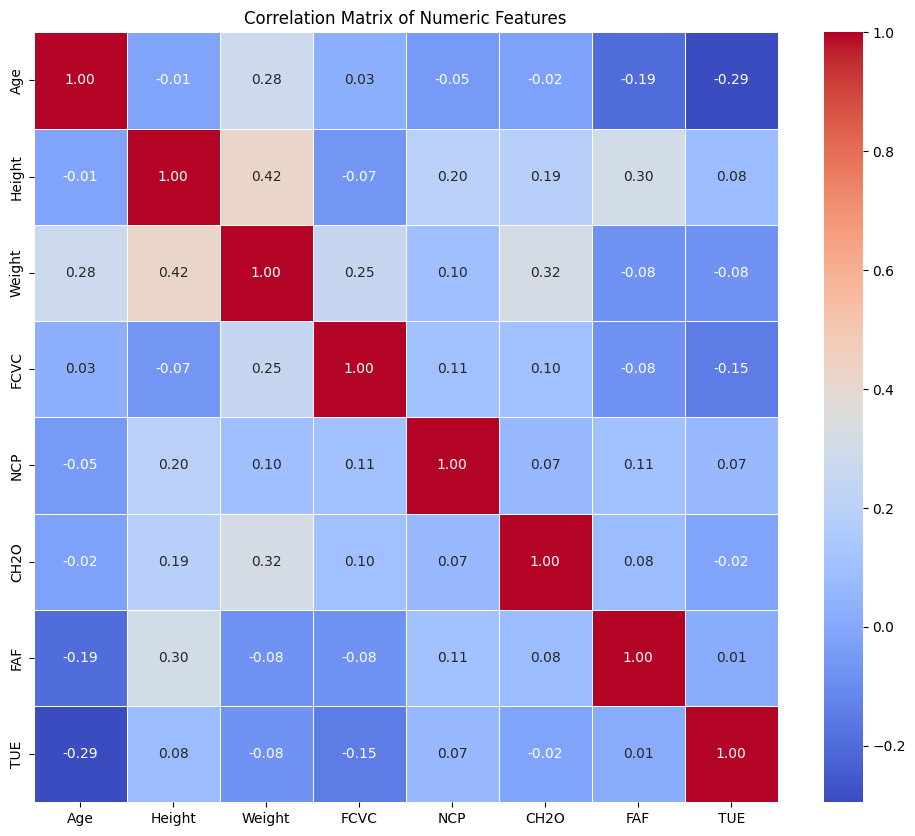

In [ ]:

numeric_cols = X.select_dtypes(include=np.number).columns
corr_matrix = X[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [ ]:

from sklearn.metrics import classification_report


oof_pred_labels = oof_preds.argmax(axis=1)


min_len = min(len(oof_labels), len(oof_pred_labels))
print("Classification Report:")
print(classification_report(oof_labels[:min_len], oof_pred_labels[:min_len], target_names=label_enc.classes_))

Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       0.93      0.93      0.93      1870
      Normal_Weight       0.88      0.89      0.89      2345
     Obesity_Type_I       0.89      0.88      0.89      2207
    Obesity_Type_II       0.97      0.97      0.97      2403
   Obesity_Type_III       1.00      1.00      1.00      2983
 Overweight_Level_I       0.82      0.79      0.80      1844
Overweight_Level_II       0.81      0.82      0.81      1881

           accuracy                           0.91     15533
          macro avg       0.90      0.90      0.90     15533
       weighted avg       0.91      0.91      0.91     15533

